<a href="https://colab.research.google.com/github/sanadv/MLCourse/blob/main/Lesson_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

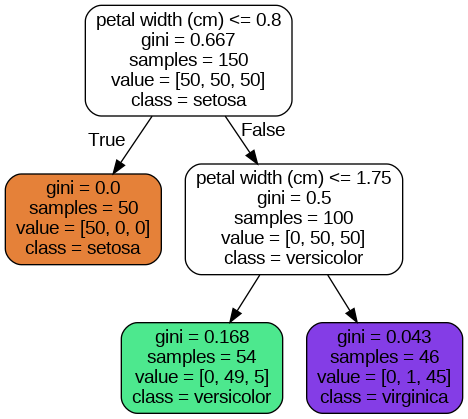

In [10]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image

# Load iris dataset
iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

# Initialize and train decision tree classifier
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

# Export decision tree to .dot file
dot_file_path = "/content/iris_tree.dot" # Directly specify the path here
export_graphviz(
    tree_clf,
    out_file=dot_file_path,
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

# Step 3: Convert the .dot file to a PNG image
png_file_path = '/content/iris_tree.png'
!dot -Tpng {dot_file_path} -o {png_file_path}

# Step 4: Display the PNG image
Image(png_file_path)

In [ ]:
# 4.1 Dicision Tree with Gini Impurity
# Sample dataset: [Feature1: Can Fly, Feature2: Has Fins, Label: Class]
data = [
    ["Yes", "No", "Bird"],
    ["No", "Yes", "Fish"],
    ["No", "No", "Mammal"],
    ["No", "Yes", "Fish"],
    ["Yes", "No", "Bird"],
    ["No", "No", "Mammal"],
    ["Yes", "No", "Bird"],
    ["No", "Yes", "Fish"],
    ["No", "No", "Mammal"]
]
def gini_impurity(groups, classes):
    # Count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # Sum weighted Gini impurity for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        if size == 0:  # avoid division by zero
            continue
        score = 0.0
        # Score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # Weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini

def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] == value:
            left.append(row)
        else:
            right.append(row)
    return left, right

def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_impurity(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d = %s]' % ((depth*' ', node['index']+1, node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ',node)))

# Build and print the decision tree
tree = build_tree(data, max_depth=3, min_size=1)
print_tree(tree)

def predict(node, row):
    if row[node['index']] == node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

# Example of making a prediction
sample = ["No", "Yes", "Bird"]  # New sample for prediction
prediction = predict(tree, sample)
print('Predicted class: %s' % prediction)


[X1 = Yes]
 [X1 = Yes]
  [Bird]
  [Bird]
 [X2 = Yes]
  [X1 = No]
   [Fish]
   [Fish]
  [X1 = No]
   [Mammal]
   [Mammal]
Predicted class: Fish



Dataset
The dataset consists of examples with two features ("Can Fly", "Has Fins") and a label indicating the class ("Bird", "Fish", "Mammal").

`gini_impurity(groups, classes)`
This function calculates the Gini impurity for a set of groups. Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it were randomly labeled according to the distribution of labels in the subset.
- `groups`: A list of groups where each group contains rows from the dataset that have been split based on a feature value.
- `classes`: A list of unique class labels in the dataset.
- It calculates the weighted Gini impurity for each group and sums them to get the overall Gini impurity for the split.

`test_split(index, value, dataset)`
This function tests a potential split on the dataset based on a given feature index and feature value.
- `index`: The index of the feature to split on.
- `value`: The value of the feature to split by.
- It divides the dataset into two groups: one where the feature value matches the split value and one where it doesn't.

`get_split(dataset)`
This function iterates over each feature and its unique values to find the best split, measured by the lowest Gini impurity.
- It returns a dictionary containing the index of the best feature to split on, the value of that feature for the split, and the two groups of data created by the split.

`to_terminal(group)`
This function creates a terminal node predicted output. It selects the most common output value among a set of rows and uses this as the prediction for the terminal node.
- `group`: A subset of the dataset that has been split down to a leaf in the tree.

`split(node, max_depth, min_size, depth)`
This function recursively splits nodes until the tree reaches a specified maximum depth or the nodes are sufficiently pure (as measured by `min_size`, the minimum number of samples a node must have to consider splitting further).
- `node`: The current node to split.
- `max_depth`: The maximum depth of the tree.
- `min_size`: The minimum size of a node.
- `depth`: The current depth of the node in the tree.

`build_tree(train, max_depth, min_size)`
This function builds the decision tree using the training data.
- `train`: The training dataset.
- It initializes the root of the tree using the best split and recursively splits each branch using the `split` function.

`print_tree(node, depth=0)`
This function prints the tree structure, showing splits on features and the resulting predictions at terminal nodes.
- `node`: The current node in the tree to print.
- `depth`: The current depth of the node in the tree, used for indentation.

`predict(node, row)`
This function makes a prediction for a given row of data by traversing the tree and following the splits until reaching a terminal node.
- `node`: The current node in the tree.
- `row`: The row of data to predict.

Execution Example
The tree is built and printed using the sample dataset. Then, the `predict` function is used to classify a new sample. The output indicates the predicted class based on the constructed decision tree.

This implementation is a basic example of how decision trees work. It highlights key concepts like splitting based on Gini impurity and recursively building the tree. This example is designed for educational purposes and might not be efficient or suitable for production use compared to optimized libraries like scikit-learn.

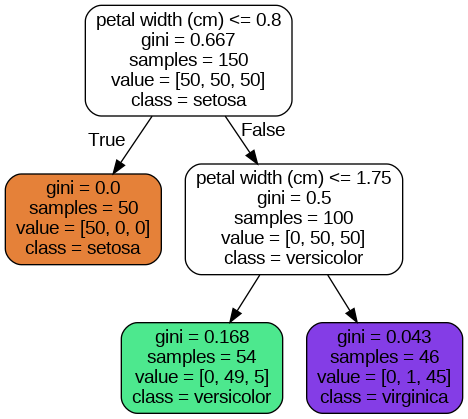